<a href="https://colab.research.google.com/github/pharringtonp19/econometrics/blob/main/notebooks/approximation/Diff_in_Diff_Linear_Issues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title **Imports** { display-mode: "form" }
from functools import partial 
import jax 
import jax.numpy as jnp 
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
#@title **Conditional Expectation Function** { display-mode: "form" }
def cef(x, t):
  return x**3 +x**2*t

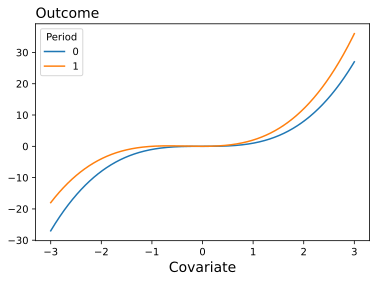

In [8]:
for t in [0,1]:
  xs = jnp.linspace(-3., 3., 1000)
  ys = partial(cef, t=t)(xs)
  plt.plot(xs, ys, label=t)
plt.title('Outcome', loc='left', size=14)
plt.xlabel('Covariate', size=14)
plt.legend(title='Period')
plt.show()

In [21]:
#@title **Sample Function** { display-mode: "form" }
def sample(key):
  subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 4)
  x = jax.random.uniform(subkey1, minval=-3., maxval=3.)
  d = jax.random.bernoulli(subkey2, jax.nn.sigmoid(x))
  t = jax.random.bernoulli(subkey3, p=0.5)
  y = cef(x, t) + 0.2*jax.random.normal(subkey4)
  return y, x, d, t 

In [22]:
#@title **Estimator** { display-mode: "form" }
def estimate(key):
  ys, xs, ds, ts = jax.vmap(sample)(jax.random.split(key, 500))
  ys, xs, ds, ts = jnp.reshape(ys, (-1,1)), jnp.reshape(xs, (-1,1)), jnp.reshape(ds, (-1,1)), jnp.reshape(ds, (-1,1))
  regs = jnp.hstack((ds*ts, ds, jnp.ones_like(ds), ts, xs))
  coef = jnp.linalg.lstsq(regs, ys)[0][0]
  return coef

In [23]:
#@title **Simulation** { display-mode: "form" }
estimates = jax.vmap(estimate)(jax.random.split(jax.random.PRNGKey(0), 20000)).reshape(-1,)
normalized_estimates = estimates/jnp.std(estimates)

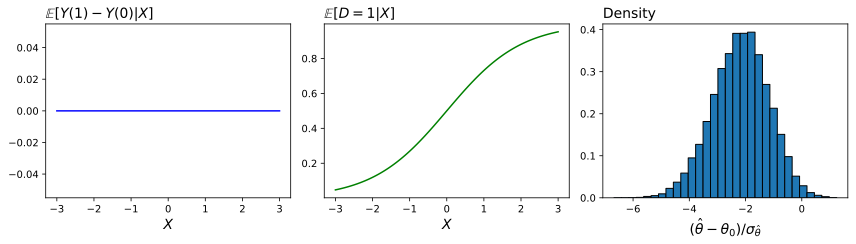

In [26]:
xs = jnp.linspace(-3., 3., 100)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, dpi=300, figsize=(12,3.5), tight_layout=True)
ax1.plot(xs, jnp.zeros_like(xs), color='blue')
ax1.set_title(r'$\mathbb{E}[Y(1) - Y(0)|X]$', loc='left', size=14)
ax1.set_xlabel(r'$X$', size=14)
ys = jax.vmap(jax.nn.sigmoid)(xs)
ax2.plot(xs, ys, color='green')
ax2.set_title(r'$\mathbb{E}[D=1|X]$', loc='left', size=14)
ax2.set_xlabel(r'$X$', size=14)
ax3.hist(normalized_estimates, edgecolor='black', bins=30, density=True)
ax3.set_title('Density', loc='left', size=14)
ax3.set_xlabel(r'$(\hat{\theta} - \theta_0)/ \sigma_{\hat{\theta}}$', size=14)
filename='diff_n_diff_linear_issues.png'
fig.savefig(filename, format="png")
plt.show()